# Text Prediction Using LSTM

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# Imports
import sys
import numpy as np
import string, os 
import pandas as pd
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop

In [5]:
text = '/content/gdrive/MyDrive/ti.txt'
raw_text = open(text, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

In [6]:
def clean_text(txt):
    punct = ['{','}','$','%','&','#','*','/',':',';','?','@','_','[',']']
    txt = "".join(v for v in txt if v not in punct).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    raw = ""
    for line in txt:
      stripped_line = line.rstrip('\n')
      raw += stripped_line
    new_text = ''.join(c for c in raw if not c.isdigit())
    return new_text

In [7]:
new_text = clean_text(raw_text)

In [8]:
new_text[0:8000]

"the project gutenberg ebook of treasure island, by robert louis stevensonthis ebook is for the use of anyone anywhere in the united states and mostother parts of the world at no cost and with almost no restrictionswhatsoever.  you may copy it, give it away or re-use it under the terms ofthe project gutenberg license included with this ebook or online atwww.gutenberg.org.  if you are not located in the united states, you'll haveto check the laws of the country where you are located before using this ebook.title treasure islandauthor robert louis stevensonillustrator louis rheadrelease date march ,  ebook most recently updated october , language englishcharacter set encoding utf- start of this project gutenberg ebook treasure island produced by judy boss, john hamm, arthur dibianca and david widgertreasure islandby robert louis stevensontreasure islandto s.l.o., an american gentleman in accordance with whose classic tastethe following narrative has been designed, it is now, in return fo

In [9]:
chars = sorted(list(set(new_text)))
print(chars)
print(len(chars))

[' ', '!', '"', "'", '(', ')', ',', '-', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
35


In [10]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
char_to_int

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 'a': 9,
 'b': 10,
 'c': 11,
 'd': 12,
 'e': 13,
 'f': 14,
 'g': 15,
 'h': 16,
 'i': 17,
 'j': 18,
 'k': 19,
 'l': 20,
 'm': 21,
 'n': 22,
 'o': 23,
 'p': 24,
 'q': 25,
 'r': 26,
 's': 27,
 't': 28,
 'u': 29,
 'v': 30,
 'w': 31,
 'x': 32,
 'y': 33,
 'z': 34}

In [11]:
int_to_char = dict((i, c) for i, c in enumerate(chars))
int_to_char

{0: ' ',
 1: '!',
 2: '"',
 3: "'",
 4: '(',
 5: ')',
 6: ',',
 7: '-',
 8: '.',
 9: 'a',
 10: 'b',
 11: 'c',
 12: 'd',
 13: 'e',
 14: 'f',
 15: 'g',
 16: 'h',
 17: 'i',
 18: 'j',
 19: 'k',
 20: 'l',
 21: 'm',
 22: 'n',
 23: 'o',
 24: 'p',
 25: 'q',
 26: 'r',
 27: 's',
 28: 't',
 29: 'u',
 30: 'v',
 31: 'w',
 32: 'x',
 33: 'y',
 34: 'z'}

In [12]:
print('---Summary---')
n_chars = len(new_text)
n_vocab = len(chars)
print("corpus length by character ", n_chars)
print("Vocab length: ", n_vocab)

---Summary---
corpus length by character  370729
Vocab length:  35


In [13]:
seq_length = 100 
step_length = 10

sentences = []    
next_chars = []   

for i in range(0, n_chars - seq_length, step_length): 
    sentences.append(new_text[i: i + seq_length])  #X
    next_chars.append(new_text[i + seq_length])  #y

In [14]:
sentences[0:10]

['the project gutenberg ebook of treasure island, by robert louis stevensonthis ebook is for the use o',
 't gutenberg ebook of treasure island, by robert louis stevensonthis ebook is for the use of anyone a',
 'g ebook of treasure island, by robert louis stevensonthis ebook is for the use of anyone anywhere in',
 ' treasure island, by robert louis stevensonthis ebook is for the use of anyone anywhere in the unite',
 'island, by robert louis stevensonthis ebook is for the use of anyone anywhere in the united states a',
 ' robert louis stevensonthis ebook is for the use of anyone anywhere in the united states and mostoth',
 'uis stevensonthis ebook is for the use of anyone anywhere in the united states and mostother parts o',
 'sonthis ebook is for the use of anyone anywhere in the united states and mostother parts of the worl',
 'ook is for the use of anyone anywhere in the united states and mostother parts of the world at no co',
 ' the use of anyone anywhere in the united states and 

In [15]:
n_sentences = len(sentences)    # no of sentences 
n_sentences 

37063

In [16]:
# creating a boolean array for each sentence, with no of characters as element

x = np.zeros((n_sentences, seq_length, n_vocab), dtype=np.bool)
y = np.zeros((n_sentences, n_vocab), dtype=np.bool)

In [17]:
# mapping chars to numbers
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

In [18]:
x.shape,y.shape

((37063, 100, 35), (37063, 35))

In [19]:
# selecting the one with high prob like softmax
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas)

In [20]:
## Double layer lstm

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 128)          83968     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 35)                4515      
Total params: 220,067
Trainable params: 220,067
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [22]:
# Fit the model

history = model.fit(x, y,batch_size=128,epochs=50,callbacks=callbacks_list)
model.save('double_layer_lstm_50epochs.h5')

Epoch 1/50
290/290 [==============================] - 38s 49ms/step - loss: 2.8190

Epoch 00001: loss improved from inf to 2.50399, saving model to saved_weights/saved_weights-01-2.5040.hdf5
Epoch 2/50
290/290 [==============================] - 14s 48ms/step - loss: 2.1023

Epoch 00002: loss improved from 2.50399 to 2.05312, saving model to saved_weights/saved_weights-02-2.0531.hdf5
Epoch 3/50
290/290 [==============================] - 14s 49ms/step - loss: 1.9185

Epoch 00003: loss improved from 2.05312 to 1.90189, saving model to saved_weights/saved_weights-03-1.9019.hdf5
Epoch 4/50
290/290 [==============================] - 14s 49ms/step - loss: 1.7935

Epoch 00004: loss improved from 1.90189 to 1.79876, saving model to saved_weights/saved_weights-04-1.7988.hdf5
Epoch 5/50
290/290 [==============================] - 14s 50ms/step - loss: 1.7111

Epoch 00005: loss improved from 1.79876 to 1.72041, saving model to saved_weights/saved_weights-05-1.7204.hdf5
Epoch 6/50
290/290 [=========

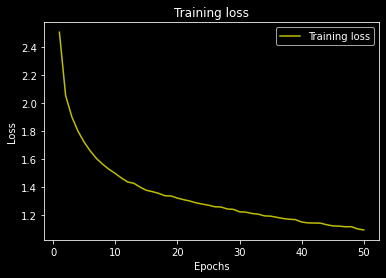

In [23]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
def fin_pred(preds):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds)
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1) 
  return np.argmax(probas)

In [38]:
def output(char_len):
  start_index = random.randint(0, n_chars - seq_length - 1)
  generated_text =''
  sentence= raw_text[start_index: start_index + seq_length]
  generated_text += sentence
  print(" Seed for prediction: "+sentence + "--->")
  for i in range(char_len):
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
      red_list = ["\n","'",';','"']
      if char not in red_list:
        x_pred[0, t, char_to_int[char]] = 1.
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = fin_pred(preds)
    next_char = int_to_char[next_index]

    generated_text += next_char
    sentence = sentence[1:] + next_char
    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

In [39]:
output(400)

 Seed for prediction: a live thing in the scuppers.

suddenly the hispaniola came right into the wind. the jibs behind me
--->
repland.or of this . and side, like a mutpase to vave a give him we could see the mething        reheld the inn this strong below i should five caped away all to, firs the hat down i regarse after but slee a doubleother, betwing this nothing i could or to be isgan, seemed between up his cruech should dust, and like themisher--on his and a deast flan than had long jive oy. when i cant leaved to it 

In [40]:
gen = output(10000)

 Seed for prediction: nd the rest eddied about the house and kept us coughing and piping
the eye.

add to this that gray, --->
the were upon that pirce the side stood bent to the mame, whre had not hreen that is have since like a duit of the sail man, and it we could see his post a last i could reat side falle a side and there for the lockoh, with dlind awwerned it said he, and i saved the opened, and there come think went, fringtorgether of the captain hisstarce and treturn, we took the barkshow may of the other side dair, but silver himself to when i to kee down scalled the crairecuate of the hills capns to i could he was not uit and nowhen co dared the turse had sust at we all me sine to and thecet at leperhape who the pock in the man to the sun for seaman to thats so rast a cook sbotionly shebesating surparce and i bullation for like amos. i dont had and gune, sir, and i save i say seen to grot, a peatring and could was bit three were left in the orrare down to the full pintry wasc